In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import TheilSenRegressor, LinearRegression
import pymannkendall as mk
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.inspection import permutation_importance



import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/home/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [2]:
def plot_correlation_matrix(comp_gridded, title=None):
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(comp_gridded.T)
    
    # Define variable names
    var_names = ['Mar SWE', 'Mean Temp', 'Median Temp', 
                 'T5 - T50', 'T95 - T50', 'Climatology']
    
    # Create figure with appropriate size
    plt.figure(figsize=(6, 5))
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                xticklabels=var_names,
                yticklabels=var_names,
                cmap='RdBu_r',  # Red-Blue diverging colormap, reversed
                vmin=-1, vmax=1,  # Fix the range of correlations
                center=0,  # Center the colormap at zero
                annot=True,  # Show correlation values
                fmt='.2f',  # Format annotations to 2 decimal places
                square=True,  # Make the plot square
                cbar_kws={'label': 'Correlation Coefficient'})
    if title:
        plt.title(title)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Usage:
# fig = plot_correlation_matrix(comp_gridded)
# plt.show()

In [3]:
# i concatenated two chunks of codes here and you may find duplicate variables (t_50 and temp_median)
# but im too lazy to clean it up so bear with me
# read processed data from pkl file
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]
climatology = np.mean(temp, axis=0)

temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
t_50 = np.zeros((39, 90, 360))
t_95 = np.zeros((39, 90, 360))
t_5 = np.zeros((39, 90, 360))

for yy in range(39):
    left, right = yy*151, (yy+1)*151

    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

    t50 = np.percentile(temp[left:right, :, :], 50, axis=0)
    t95 = np.percentile(temp[left:right, :, :], 95, axis=0)
    t5 = np.percentile(temp[left:right, :, :], 5, axis=0)
    t_50[yy, :, :] = t50
    t_95[yy, :, :] = t95
    t_5[yy, :, :] = t5

# mask out nan values in temperatures
mask = 1 - np.isnan(np.mean(temp_mean, axis=0))
# the 1-deg mask (mask2) is downscaled from the 2-deg from Gottlieb 2024 et al.
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [4]:
swe_gridded = np.loadtxt('swe_gridded_1deg.txt')
swe_insitu = np.loadtxt('swe_insitu_1deg.txt')

comp_gridded = []
comp_insitu = []
climatology_group_map = np.zeros((90, 360))

xx = np.arange(39)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)
        
        lm_mean = TheilSenRegressor(random_state=42)
        lm_mean.fit(xx[:,None], temp_mean[:,i,j])

        # 50th, 95th, and 5th percentile trends
        lm50 = TheilSenRegressor(random_state=42)
        lm50.fit(xx[:,None], t_50[:,i,j])

        lm5 = TheilSenRegressor(random_state=42)
        lm5.fit(xx[:,None], t_5[:,i,j])

        lm95 = TheilSenRegressor(random_state=42)
        lm95.fit(xx[:,None], t_95[:,i,j])

        comp_gridded.append((swe_gridded[i,j],
                             lm_mean.coef_[0] * 10,
                             lm50.coef_[0] * 10,
                             (lm5.coef_[0] - lm50.coef_[0]) * 10,
                             (lm95.coef_[0] - lm50.coef_[0]) * 10,
                             climatology[i,j]))
        if swe_insitu[i,j]:
            comp_insitu.append((swe_insitu[i,j],
                             lm_mean.coef_[0] * 10,
                             lm50.coef_[0] * 10,
                             (lm5.coef_[0] - lm50.coef_[0]) * 10,
                             (lm95.coef_[0] - lm50.coef_[0]) * 10,
                             climatology[i,j]))
        if climatology[i,j] <= -20:
            climatology_group_map[i,j] = 1
        elif climatology[i,j] <= -10:
            climatology_group_map[i,j] = 2
        elif climatology[i,j] <= 0:
            climatology_group_map[i,j] = 3
        else:
            climatology_group_map[i,j] = 4

comp_gridded = np.array(comp_gridded)
comp_insitu = np.array(comp_insitu)
# Create mask for rows where March SWE <= 2
mask_gridded = comp_gridded[:, 0] <= 2
comp_gridded = comp_gridded[mask_gridded]

mask_insitu = comp_insitu[:, 0] <= 2
comp_insitu = comp_insitu[mask_insitu]

# comp_gridded[:,0]: Mar SWE trend from Gottlieb et al. 2024
# comp_gridded[:,1]: trend of mean temperature
# comp_gridded[:,2]: trend of median temperature
# comp_gridded[:,3]: cold tail outpacing
# comp_gridded[:,4]: warm tail outpacing
# comp_gridded[:,5]: climatological temperature
# same for comp_insitu        

Processing  1000  grids. Time taken so far:  35.82860016822815
Processing  2000  grids. Time taken so far:  73.31349873542786
Processing  3000  grids. Time taken so far:  111.10961699485779
Processing  4000  grids. Time taken so far:  149.00191974639893
Processing  5000  grids. Time taken so far:  188.22238969802856
Processing  6000  grids. Time taken so far:  228.0078604221344
Processing  7000  grids. Time taken so far:  268.18862986564636


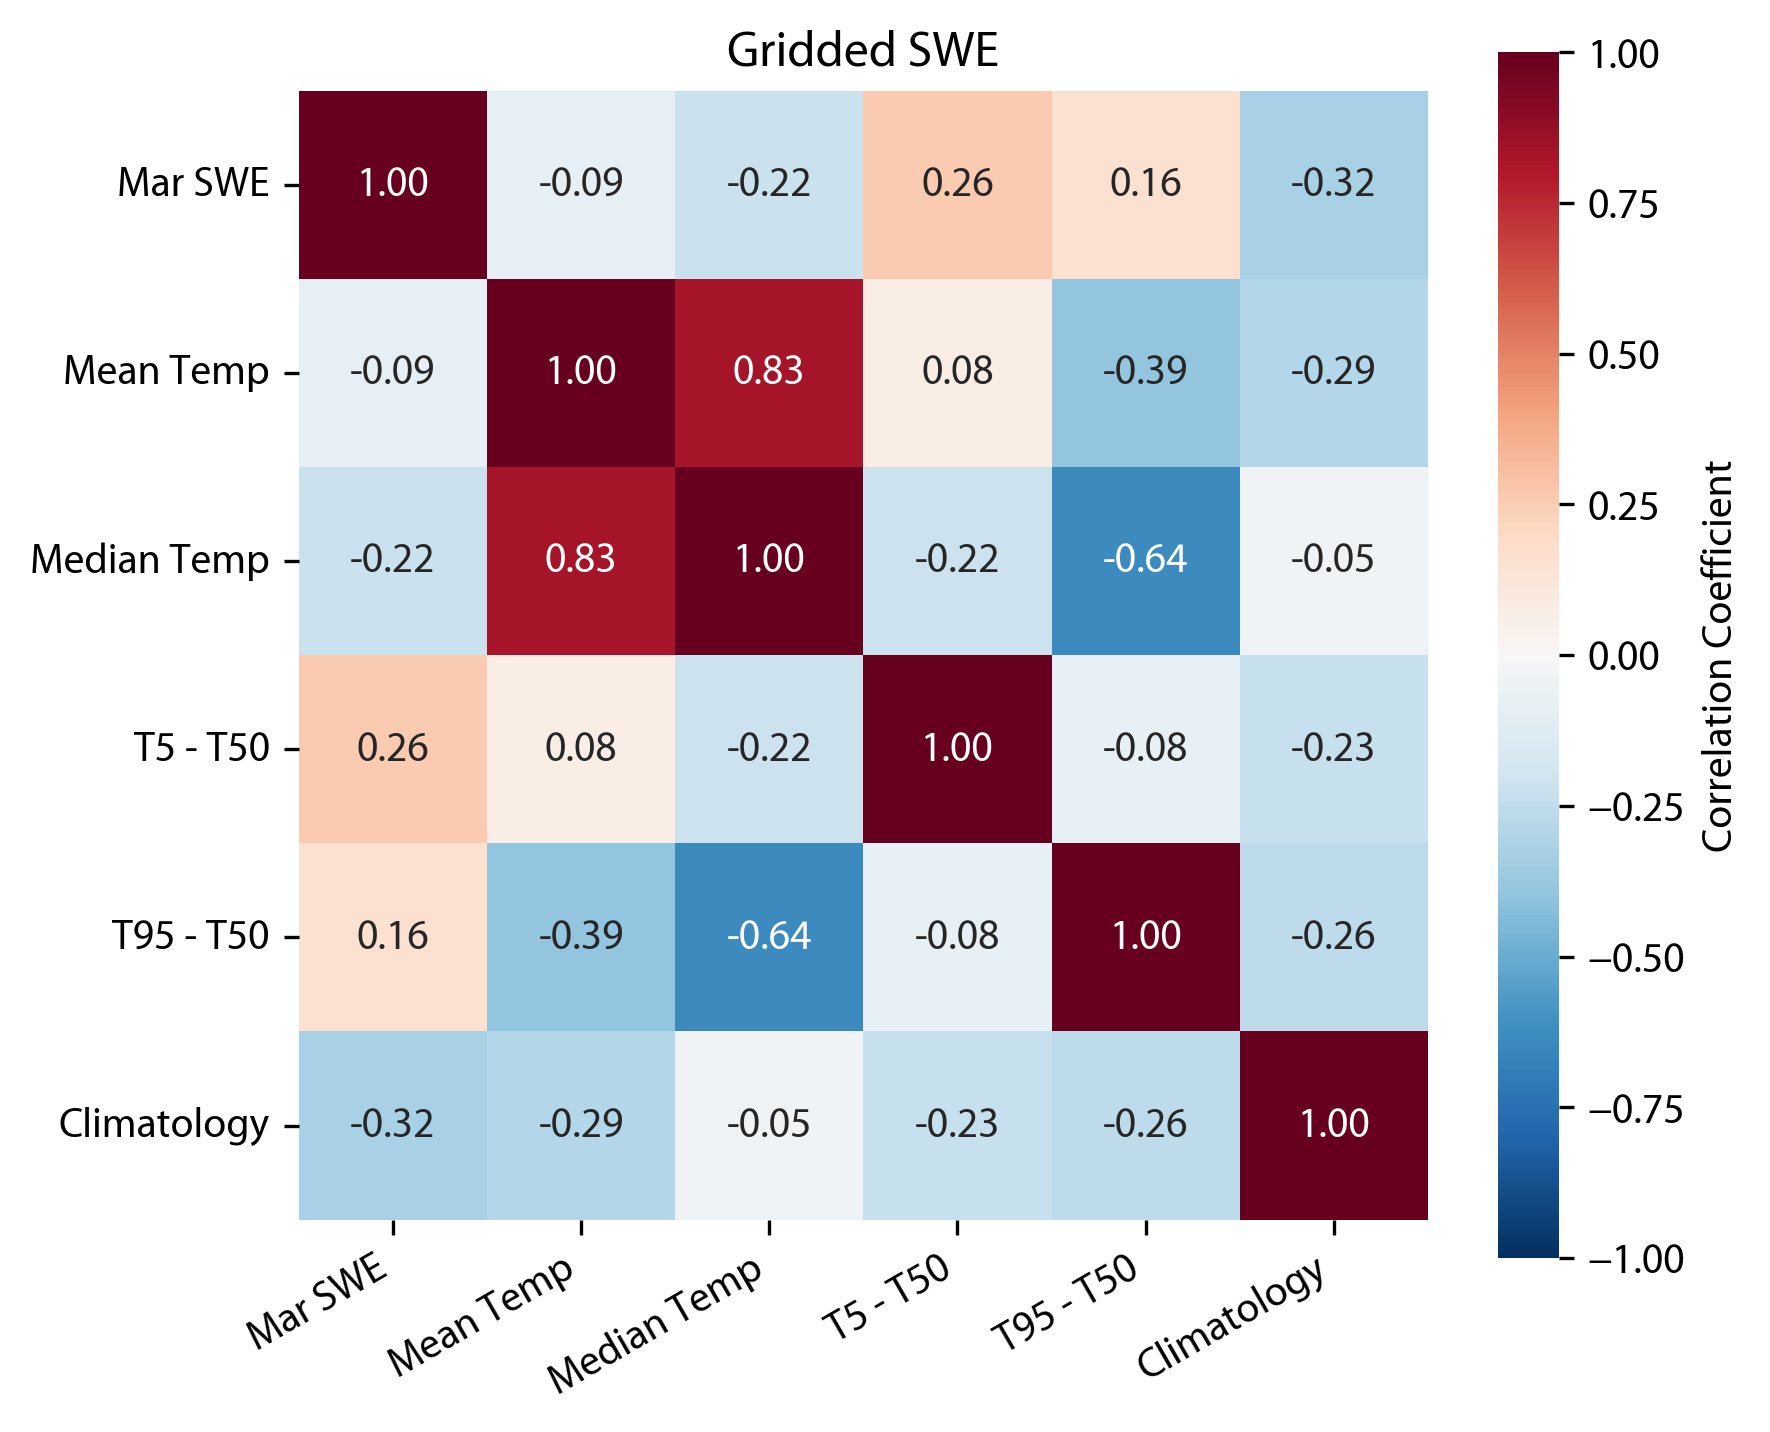

In [5]:
fig = plot_correlation_matrix(comp_gridded, title='Gridded SWE')
plt.show()
fig.savefig('figures_new/corr_gridded_swe.png')

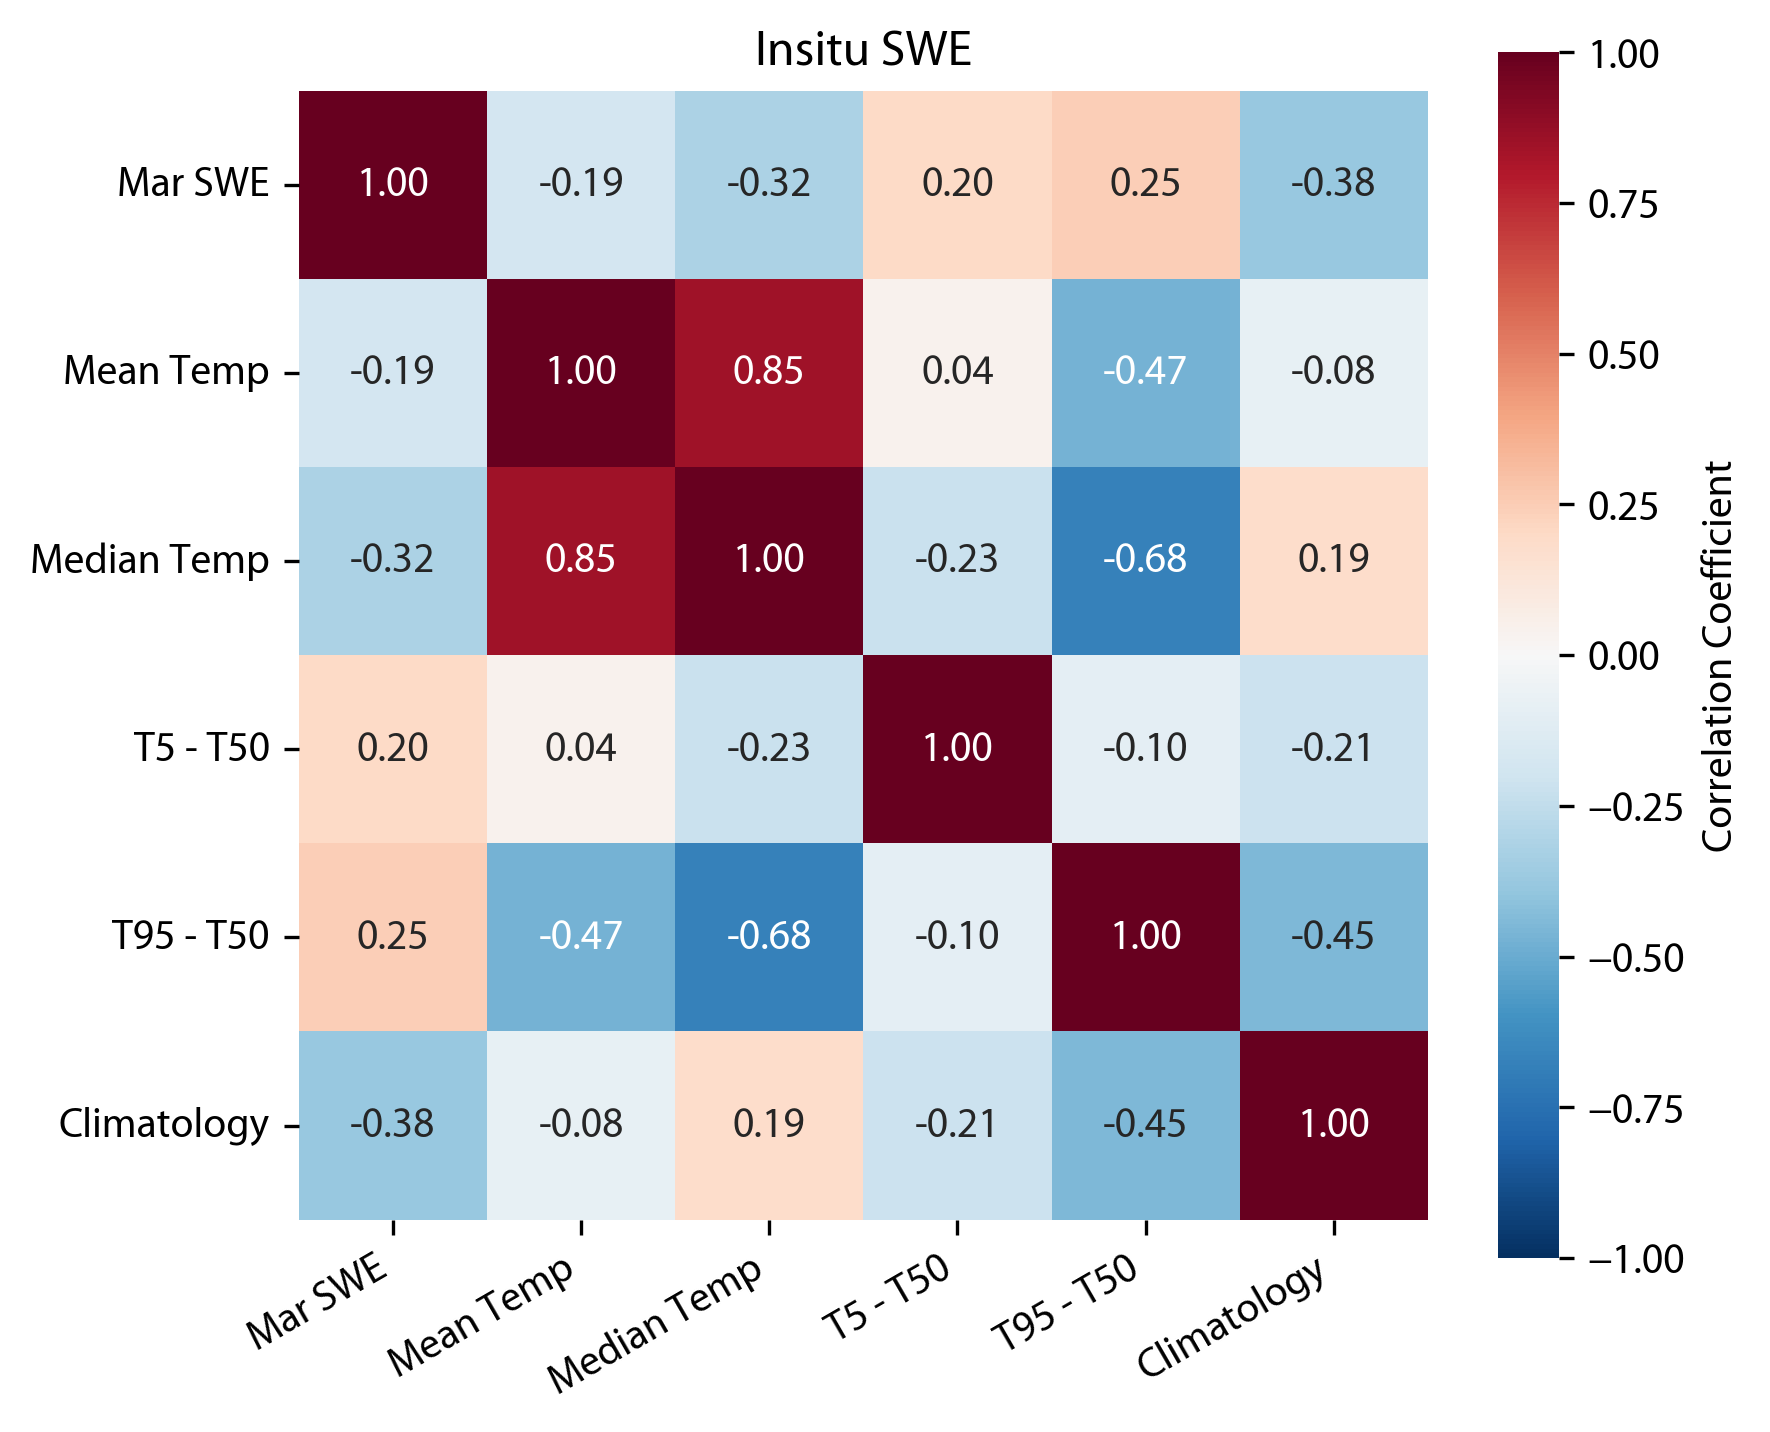

In [6]:
fig = plot_correlation_matrix(comp_insitu, title='Insitu SWE')
plt.show()
fig.savefig('figures_new/corr_insitu_swe.png')

In [7]:
# comp_gridded[:,0]: Mar SWE trend from Gottlieb et al. 2024
# comp_gridded[:,1]: trend of mean temperature
# comp_gridded[:,2]: trend of median temperature
# comp_gridded[:,3]: cold tail outpacing
# comp_gridded[:,4]: warm tail outpacing
# comp_gridded[:,5]: climatological temperature
# same for comp_insitu        

XX = {}
# XX[0]: mean temperature
# XX[1]: median temperature
# XX[2]: median temperature + cold tail outpacing
# XX[3]: median temperature + warm tail outpacing
# XX[4]: median temperature + cold tail outpacing + warm tail outpacing
XX[0] = np.concatenate([comp_gridded[:,1][:,None], comp_gridded[:,5][:,None]], axis=1)
XX[1] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,5][:,None]], axis=1)
XX[2] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None], comp_gridded[:,5][:,None]], axis=1)
XX[3] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,4][:,None], comp_gridded[:,5][:,None]], axis=1)
XX[4] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None], 
                        comp_gridded[:,4][:,None], comp_gridded[:,5][:,None]], axis=1)

for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_gridded[:,0])
    print(np.sqrt(lm.score(XX[i], comp_gridded[:,0])))

0.37943453809947675
0.40227906091877125
0.42726709967088805
0.4165137627656699
0.43027363132800756


In [8]:
# comp_insitu[:,0]: Mar SWE trend from Gottlieb et al. 2024
# comp_insitu[:,1]: trend of mean temperature
# comp_insitu[:,2]: trend of median temperature
# comp_insitu[:,3]: cold tail outpacing
# comp_insitu[:,4]: warm tail outpacing
# comp_insitu[:,5]: climatological temperature
# same for comp_gridded        

XX = {}
# XX[0]: mean temperature
# XX[1]: median temperature
# XX[2]: median temperature + cold tail outpacing
# XX[3]: median temperature + warm tail outpacing
# XX[4]: median temperature + cold tail outpacing + warm tail outpacing
XX[0] = np.concatenate([comp_insitu[:,1][:,None], comp_insitu[:,5][:,None]], axis=1)
XX[1] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,5][:,None]], axis=1)
XX[2] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None], comp_insitu[:,5][:,None]], axis=1)
XX[3] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,4][:,None], comp_insitu[:,5][:,None]], axis=1)
XX[4] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None], 
                        comp_insitu[:,4][:,None], comp_insitu[:,5][:,None]], axis=1)

for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_insitu[:,0])
    print(np.sqrt(lm.score(XX[i], comp_insitu[:,0])))

0.43473054674215955
0.4523470622290995
0.45796658832319886
0.4654252381608277
0.4658931355342412


In [9]:
XX = {}
# XX[0]: mean temperature
# XX[1]: median temperature
# XX[2]: median temperature + cold tail outpacing
# XX[3]: median temperature + warm tail outpacing
# XX[4]: median temperature + cold tail outpacing + warm tail outpacing
XX[0] = comp_gridded[:,1][:,None]
XX[1] = comp_gridded[:,2][:,None]
XX[2] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None]], axis=1)
XX[3] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,4][:,None]], axis=1)
XX[4] = np.concatenate([comp_gridded[:,2][:,None], comp_gridded[:,3][:,None], 
                        comp_gridded[:,4][:,None]], axis=1)

for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_gridded[:,0])
    print(np.sqrt(lm.score(XX[i], comp_gridded[:,0])))

0.09360483964062359
0.22197406007485676
0.3136909693789605
0.22352028305850827
0.3280847265591333


In [10]:
XX = {}
XX[0] = comp_insitu[:,1][:,None]
XX[1] = comp_insitu[:,2][:,None]
XX[2] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None]], axis=1)
XX[3] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,4][:,None]], axis=1)
XX[4] = np.concatenate([comp_insitu[:,2][:,None], comp_insitu[:,3][:,None], 
                        comp_insitu[:,4][:,None]], axis=1)
for i in range(5):
    lm = LinearRegression().fit(XX[i], comp_insitu[:,0])
    print(np.sqrt(lm.score(XX[i], comp_insitu[:,0])))

0.1857529614669384
0.3164204934999878
0.3412697550457973
0.3195929108172098
0.3544581677609368


In [9]:
colors = {
    0: np.array([33, 102, 172]) / 255.,  # Cold
    1: np.array([67, 147, 195]) / 255.,  # Cool
    2: np.array([146, 197, 222]) / 255., # Mild
    3: np.array([209, 229, 240]) / 255.  # Warm
}

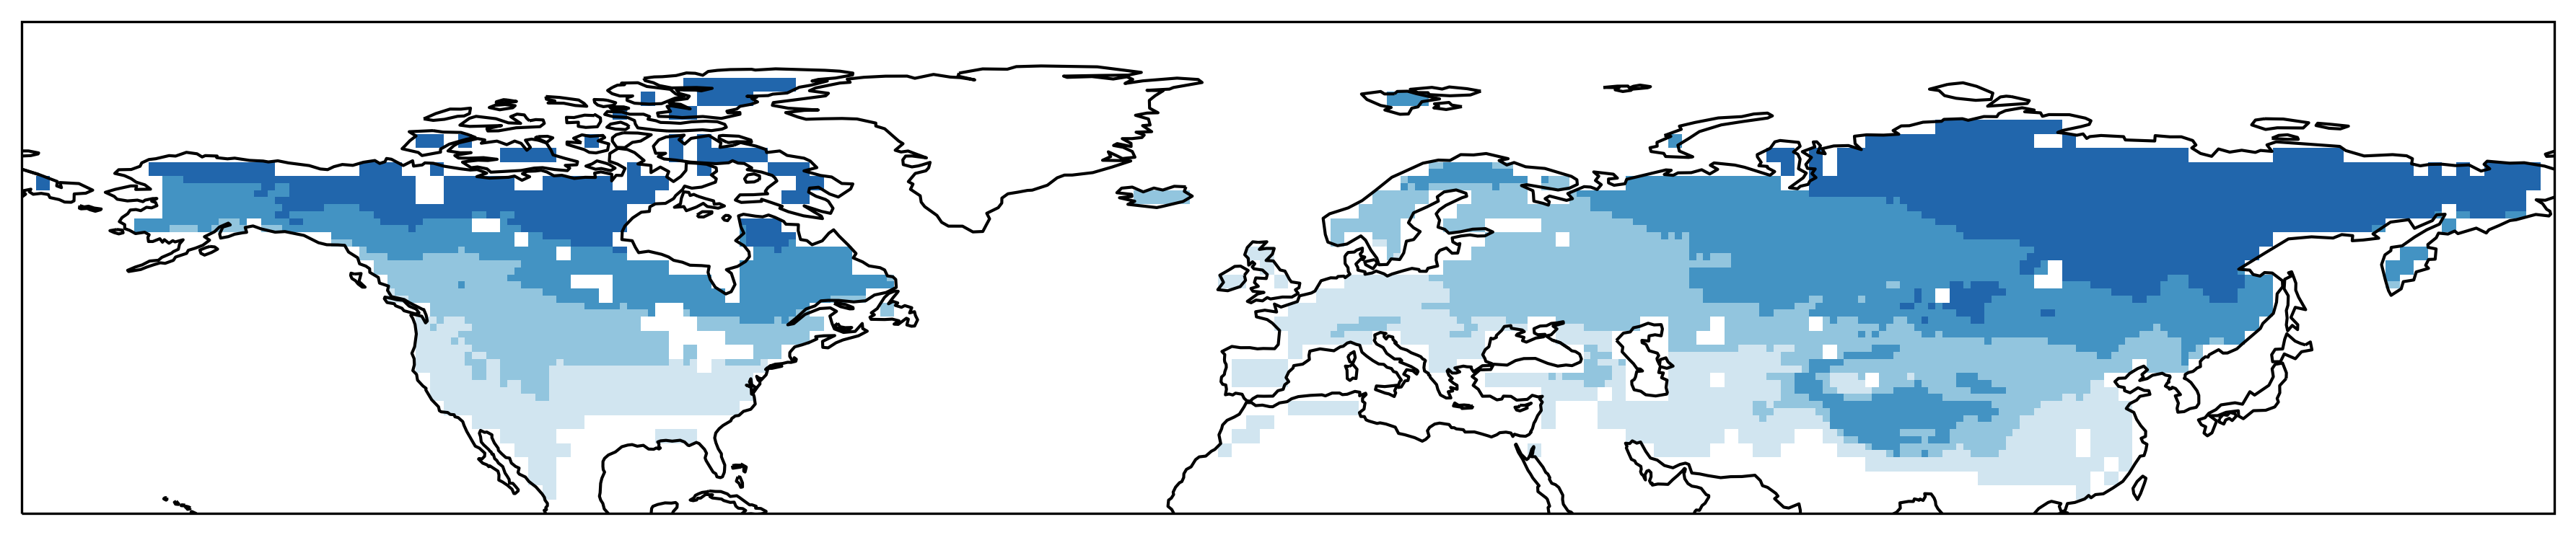

In [28]:
climatology_map_masked = np.ma.masked_where(mask == 0, climatology_group_map)
# swe_insitu_mask = np.where(swe_insitu > 0, 1, 0)
# swe_insitu_mask = np.ma.masked_where(swe_insitu_mask == 0, swe_insitu_mask)
# climatology_map_masked = np.ma.masked_where(mask == 0, np.multiply(climatology_group_map, swe_insitu_mask))

lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)

# Create the plot
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(10, 12)

# Create main map
ax = fig.add_subplot(gs[:, :], projection=ccrs.PlateCarree())

# Create custom colormap for the 4 types
# colors = ['#1f77b4',  # Type I: blue (stretch-stretch)
#           '#2ca02c',  # Type II: green (shrink-shrink)
#           '#ff7f0e',  # Type III: orange (shrink-stretch)
#           '#d62728']  # Type IV: red (stretch-shrink)
# Convert IPCC colors from 0-255 to 0-1 range
colors = {
    0: np.array([33, 102, 172]) / 255.,  # Cold
    1: np.array([67, 147, 195]) / 255.,  # Cool
    2: np.array([146, 197, 222]) / 255., # Mild
    3: np.array([209, 229, 240]) / 255.  # Warm
}

cmap = ListedColormap(list(colors[i] for i in range(4)))
norm = BoundaryNorm(boundaries=np.arange(0.5, 5.5), ncolors=4)

# Plot the map
basemap = ax.pcolormesh(lon, lat, climatology_map_masked, 
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=norm)

# Add coastlines and gridlines
ax.coastlines()
# ax.gridlines()
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
fig.savefig('figures_new/climatology_map.png')

In [40]:
# Define the bins and corresponding labels
bins = [-20, -10, 0]
# bins = [-15, 0]
label_str = ['<=' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('[' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

# Digitize climatology_v based on the bins
grouped_indices = np.digitize(comp_gridded[:,5], bins)
# grouped_indices = np.digitize(comp_insitu[:,5], bins)

comp_gridded_group = {}

for i in range(len(bins)+1):
    comp_gridded_group[i] = comp_gridded[grouped_indices == i, :]
    # comp_gridded_group[i] = comp_insitu[grouped_indices == i, :]



In [41]:

def plot_incremental_skill(rr, err):
    # Create figure
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Define bar positions
    positions = np.arange(len(rr))
    
    # Define colors for different components
    base_color = 'dimgrey'  # color for baseline bars
    increment_color = 'silver'  # color for incremental improvements
    
    # Plot the first bar (mean temperature baseline)
    ax.bar(positions[0], rr[0], width=0.6, edgecolor='black', color='None')
    # ax.plot(positions[0]*np.ones(2), err[0], color='black', linewidth=1)
    ax.plot(positions[0] + np.array([-0.3, 0.3]), err[0][1]*np.ones(2), color='black', linewidth=1)
    
    # Plot the second bar (median temperature baseline)
    ax.bar(positions[1], rr[1], width=0.6, color=base_color, edgecolor='black')
    # ax.plot(positions[1]*np.ones(2), err[1], color='black', linewidth=1)
    ax.plot(positions[1] + np.array([-0.3, 0.3]), err[1][1]*np.ones(2), color='black', linewidth=1)
    
    # Plot incremental improvements for remaining bars
    for i in range(2, len(rr)):
        # Plot the baseline part (up to median temp skill)
        ax.bar(positions[i], rr[1], width=0.6, color=base_color, edgecolor='black')
        # Plot the incremental improvement
        ax.bar(positions[i], rr[i] - rr[1], width=0.6, bottom=rr[1], color=increment_color, edgecolor='black')
    
    # Add value labels on the bars
    for i, r in enumerate(rr):
        if i < 2:
            ax.text(positions[i], err[i][1]+0.002, f'{r:.3f}', ha='center', va='bottom')
            ax.text(positions[i], err[i][1]+0.03, f'({err[i][1]-r:.3f})', ha='center', va='bottom')
        else:
            increment = r - rr[1]
            tmp_text = f'+{increment:.3f}' if increment > 0 else f'{increment:.3f}'
            ax.text(positions[i], r+0.002, tmp_text, ha='center', va='bottom')
            
    ax.set_ylim(0, 0.75)
    # Customize the plot
    ax.set_xticks(positions)
    ax.set_xticklabels(['Mean ', 'Median ', 
                        '+ Cold',
                        '+ Warm',
                        '+ Both'], 
                       rotation=0, fontsize = 12)
    
    # Add labels and title
    ax.set_yticks([])
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

the number of samples is  1791
Model 0 R score: 0.4142
Model 0 coefficients: [-0.80566416 -0.07340632]
Model 1 R score: 0.4592
Model 1 coefficients: [-0.82154773 -0.07333023]
Model 2 R score: 0.5271
Model 2 coefficients: [-0.42979469  0.37606164 -0.06061866]
Model 3 R score: 0.5001
Model 3 coefficients: [-1.13759017 -0.56429051 -0.0685381 ]
Model 4 R score: 0.5283
Model 4 coefficients: [-0.55438258  0.32995045 -0.13668402 -0.06101654]

Shapley Value Analysis for Model 4 (all predictors):
Median importance: 0.1000 ± 0.0124
Cold importance: 0.1524 ± 0.0141
Warm importance: 0.0079 ± 0.0029
Climatology importance: 0.1307 ± 0.0070

Features ranked by importance:
Cold: 0.1524
Climatology: 0.1307
Median: 0.1000
Warm: 0.0079


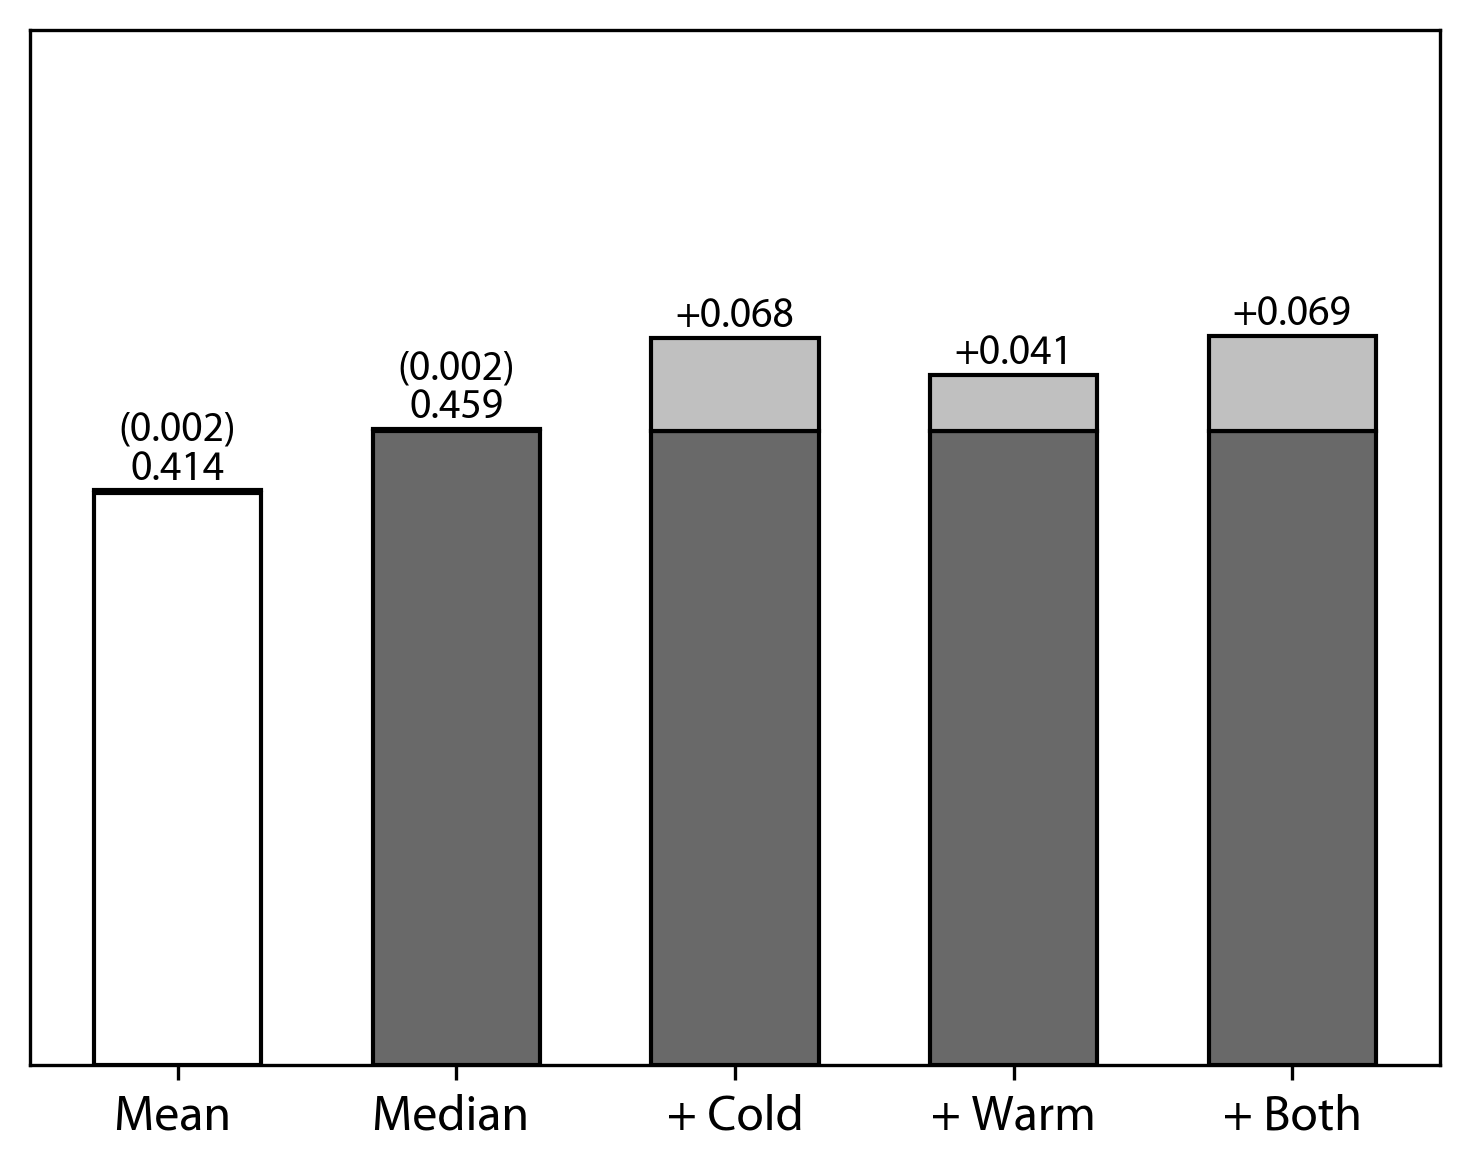

In [48]:
# Group index
k = 2

# comp_gridded[:,0]: Mar SWE trend from Gottlieb et al. 2024
# comp_gridded[:,1]: trend of mean temperature
# comp_gridded[:,2]: trend of median temperature
# comp_gridded[:,3]: cold tail outpacing
# comp_gridded[:,4]: warm tail outpacing
# comp_gridded[:,5]: climatological temperature
# same for comp_insitu        

# Create feature matrices for different model combinations
XX = {
    0: comp_gridded_group[k][:, [1,5]],  # Single column, reshaped
    1: comp_gridded_group[k][:, [2,5]],  # Single column, reshaped
    2: comp_gridded_group[k][:, [2,3,5]], # Two columns
    3: comp_gridded_group[k][:, [2,4,5]], # Two columns
    4: comp_gridded_group[k][:, [2,3,4,5]] # Three columns
}

# # Create feature matrices for different model combinations
# XX = {
#     0: comp_gridded_group[k][:, 1:2],  # Single column, reshaped
#     1: comp_gridded_group[k][:, 2:3],  # Single column, reshaped
#     2: comp_gridded_group[k][:, [2,3]], # Two columns
#     3: comp_gridded_group[k][:, [2,4]], # Two columns
#     4: comp_gridded_group[k][:, [2,3,4]] # Three columns
# }

print('the number of samples is ', len(comp_gridded_group[k][:, 0]))
# Calculate R scores for each model
rr = []
for i in range(5):
    # Fit linear regression and calculate R score
    lm = LinearRegression().fit(XX[i], comp_gridded_group[k][:, 0])
    r_score = np.sqrt(lm.score(XX[i], comp_gridded_group[k][:, 0]))
    rr.append(r_score)
    print(f"Model {i} R score: {r_score:.4f}")
    print(f"Model {i} coefficients: {lm.coef_}")


# Get feature names for model 4
feature_names = ['Median', 'Cold', 'Warm', 'Climatology']

# Fit the model again
model_4 = LinearRegression().fit(XX[4], comp_gridded_group[k][:, 0])

# Calculate permutation importance (Shapley-like approach)
result = permutation_importance(
    model_4, XX[4], comp_gridded_group[k][:, 0], 
    n_repeats=10, random_state=42
)

# Print importance scores
print("\nShapley Value Analysis for Model 4 (all predictors):")
for i, name in enumerate(feature_names):
    print(f"{name} importance: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Sort features by importance
indices = np.argsort(result.importances_mean)[::-1]
print("\nFeatures ranked by importance:")
for i in indices:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.4f}")

# Save shapley value results to a dictionary with key k
if 'shapley_results' not in locals():
    shapley_results = {}
    
shapley_results[k] = {
    'feature_names': feature_names,
    'importances_mean': result.importances_mean,
    'importances_std': result.importances_std,
    'ranked_indices': indices
}

# for i = 0 or 1, add a random column to the feature variable to quantify the uncertainty
# repeat this for 100 times
# plot the distribution of the R score as error bar
err = []
for i in range(2):
    tmp_r = []
    for j in range(100):
        np.random.seed(13 + 7*j)
        tmp_xx = np.concatenate([XX[i], np.random.randn(XX[i].shape[0], 1)], axis=1)
        lm = LinearRegression().fit(tmp_xx, comp_gridded_group[k][:, 0])
        r_score = np.sqrt(lm.score(tmp_xx, comp_gridded_group[k][:, 0]))
        tmp_r.append(r_score)
    err.append([np.quantile(tmp_r, 0.05), np.quantile(tmp_r, 0.95)])

# Plot and save results
fig = plot_incremental_skill(rr, err)
plt.show()
fig.savefig(f'figures_new/skill_group_{k+1}_doublecheck.png',
            transparent=True,  # Enable transparency
            bbox_inches='tight',  # Trim extra white space
            dpi=600)



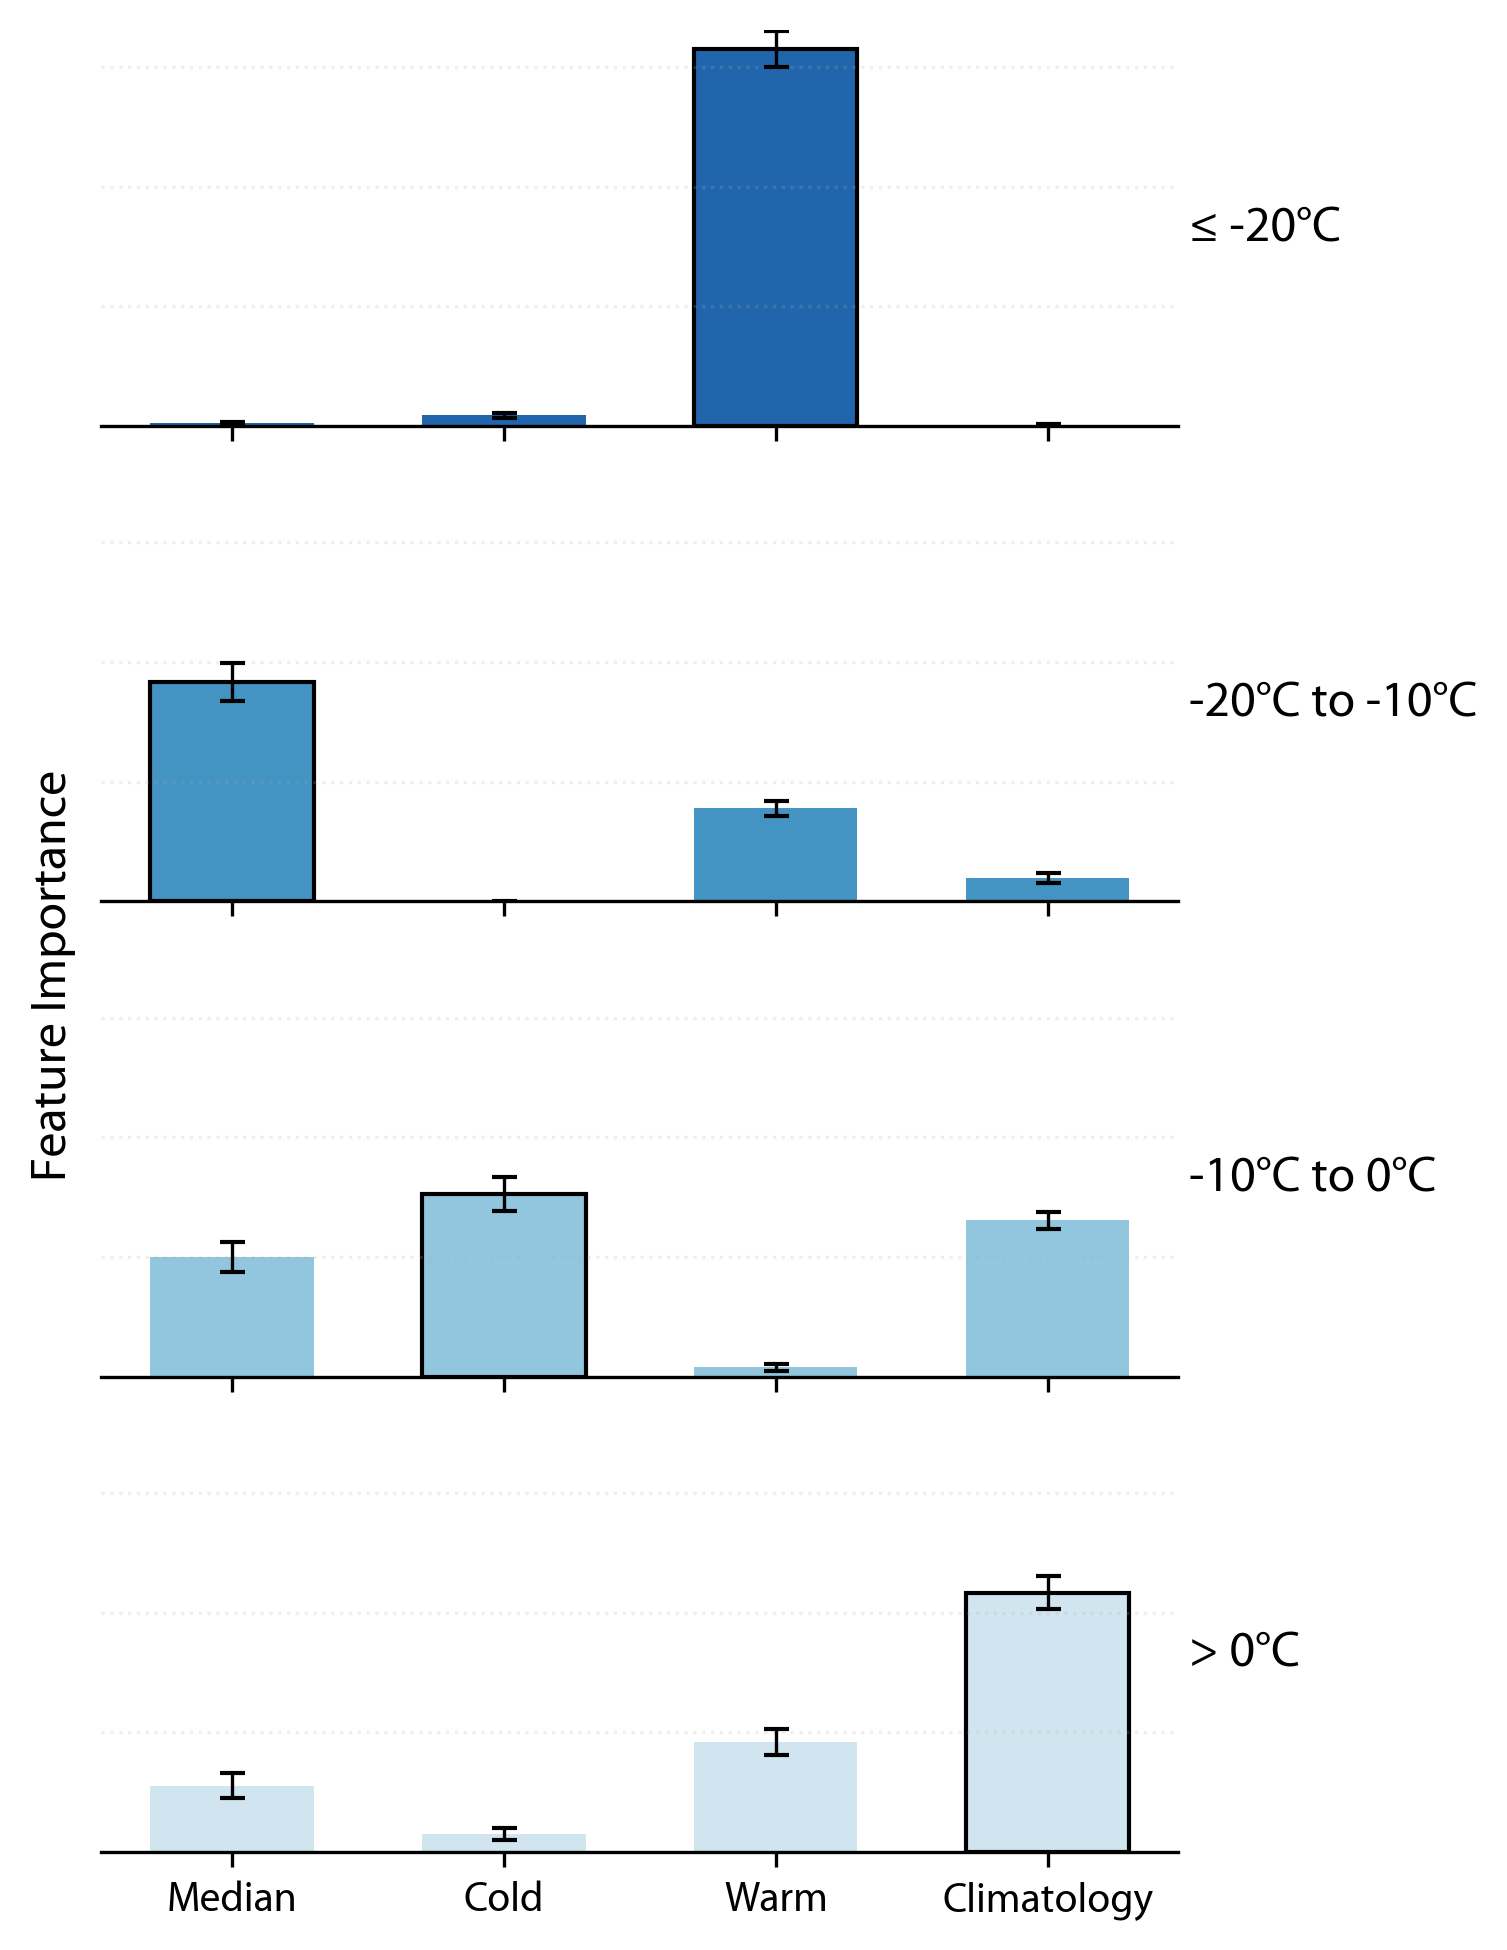

In [46]:
# Plot Shapley values for all temperature categories in a 4x1 grid
fig, axes = plt.subplots(4, 1, figsize=(4.4, 6.6), sharex=True)

# Define temperature category labels
temp_categories = [
    "≤ -20°C",
    "-20°C to -10°C",
    "-10°C to 0°C",
    "> 0°C"
]

# Use the colors from the blues colormap for consistency
colors = [
    np.array([0.12941176, 0.4       , 0.6745098 ]),
    np.array([0.2627451 , 0.57647059, 0.76470588]),
    np.array([0.57254902, 0.77254902, 0.87058824]),
    np.array([0.81960784, 0.89803922, 0.94117647])
]

# Find the maximum importance value across all groups for consistent scaling
max_importance = max([results['importances_mean'].max() for results in shapley_results.values()])

# Get feature names from the first group
feature_names = shapley_results[0]['feature_names']

# Plot each temperature category
for idx, (group_key, results) in enumerate(shapley_results.items()):
    ax = axes[idx]
    
    # Get importance values and standard deviations
    importances = results['importances_mean']
    std_devs = results['importances_std']
    
    # Create positions for bars
    positions = np.arange(len(feature_names))
    
    # Find the most important predictor
    most_important_idx = np.argmax(importances)
    
    # Plot bars
    for i, (pos, imp, std) in enumerate(zip(positions, importances, std_devs)):
        # Highlight the most important predictor
        if i == most_important_idx:
            ax.bar(pos, imp, width=0.6, color=colors[idx], edgecolor='black', linewidth=1)
        else:
            ax.bar(pos, imp, width=0.6, color=colors[idx])
        
        # Add error bars
        ax.errorbar(pos, imp, yerr=std, fmt='none', ecolor='black', capsize=3, linewidth=0.8)
    
    # Add labels - moved to the right outside the subplot
    ax.text(1.01, 0.5, temp_categories[idx], transform=ax.transAxes, 
            fontsize=12, va='center', ha='left')
    
    # Clean up appearance
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add subtle grid
    ax.grid(axis='y', linestyle=':', alpha=0.2)

# Add x-axis labels only to the bottom subplot
axes[-1].set_xticks(positions)
axes[-1].set_xticklabels(feature_names, rotation=0, ha='center', fontsize=10)

# Set consistent y-axis limits
for ax in axes:
    ax.set_ylim(0, max_importance * 1.05)

# Add a single y-axis label
fig.text(-0.02, 0.5, 'Feature Importance', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, right=0.85)  # Adjusted right margin to make room for labels

# Show and save
plt.show()
fig.savefig('figures_new/shapley_values_by_temperature.png',
            transparent=True,
            bbox_inches='tight',
            dpi=600)
